In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense


from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
#Load base model
base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

# Add new layers
x = base_model.output

x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(1024, activation='relu')(x)  # Layer 1 with 1024 nodes and ReLU activation
x = Dense(1024, activation='relu')(x)  # Layer 2 with 1024 nodes and ReLU activation
x = Dense(512, activation='relu')(x)   # Layer 3 with 512 nodes and ReLU activation

# Final prediction layer
preds = Dense(3, activation='softmax')(x)  # Layer 4 with 3 nodes (3 classes) and softmax activation


model=Model(inputs=base_model.input,outputs=preds)
model.summary()

for layer in model.layers[:86]:
    layer.trainable=False #Freeze base model
for layer in model.layers[86:]:
    layer.trainable=True

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [15]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv1
2 conv1_bn
3 conv1_relu
4 conv_dw_1
5 conv_dw_1_bn
6 conv_dw_1_relu
7 conv_pw_1
8 conv_pw_1_bn
9 conv_pw_1_relu
10 conv_pad_2
11 conv_dw_2
12 conv_dw_2_bn
13 conv_dw_2_relu
14 conv_pw_2
15 conv_pw_2_bn
16 conv_pw_2_relu
17 conv_dw_3
18 conv_dw_3_bn
19 conv_dw_3_relu
20 conv_pw_3
21 conv_pw_3_bn
22 conv_pw_3_relu
23 conv_pad_4
24 conv_dw_4
25 conv_dw_4_bn
26 conv_dw_4_relu
27 conv_pw_4
28 conv_pw_4_bn
29 conv_pw_4_relu
30 conv_dw_5
31 conv_dw_5_bn
32 conv_dw_5_relu
33 conv_pw_5
34 conv_pw_5_bn
35 conv_pw_5_relu
36 conv_pad_6
37 conv_dw_6
38 conv_dw_6_bn
39 conv_dw_6_relu
40 conv_pw_6
41 conv_pw_6_bn
42 conv_pw_6_relu
43 conv_dw_7
44 conv_dw_7_bn
45 conv_dw_7_relu
46 conv_pw_7
47 conv_pw_7_bn
48 conv_pw_7_relu
49 conv_dw_8
50 conv_dw_8_bn
51 conv_dw_8_relu
52 conv_pw_8
53 conv_pw_8_bn
54 conv_pw_8_relu
55 conv_dw_9
56 conv_dw_9_bn
57 conv_dw_9_relu
58 conv_pw_9
59 conv_pw_9_bn
60 conv_pw_9_relu
61 conv_dw_10
62 conv_dw_10_bn
63 conv_dw_10_relu
64 conv_pw_10
65 conv_pw_1

In [16]:
# Define your data augmentation parameters
rotation_range = 30
zoom_range = 0.2
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.2
horizontal_flip = True
batch_size = 16  # Adjust this to your desired batch size
seed_value = 42  # Adjust this as needed

# Create DataGenerator Object
datagen = ImageDataGenerator(
    rotation_range=rotation_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    shear_range=shear_range,
    horizontal_flip=horizontal_flip,
    preprocessing_function=preprocess_input,
    fill_mode="nearest"
)

# Specify the path to the training data directory
train_data_directory = './Ship/Train/'

# Create Train Image Generator
train_generator = datagen.flow_from_directory(
    train_data_directory,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,  # Specify your desired batch size
    class_mode='categorical',  # Assuming you are doing multi-class classification
    seed=seed_value,
    shuffle=True
)

# Specify the path to the validation data directory
validate_data_directory = './Ship/Validate/'

# Create Validation Image Generator
val_generator = datagen.flow_from_directory(
    validate_data_directory,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,  # Specify your desired batch size
    class_mode='categorical',  # Assuming you are doing multi-class classification
    seed=seed_value,
    shuffle=True
)

Found 97 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


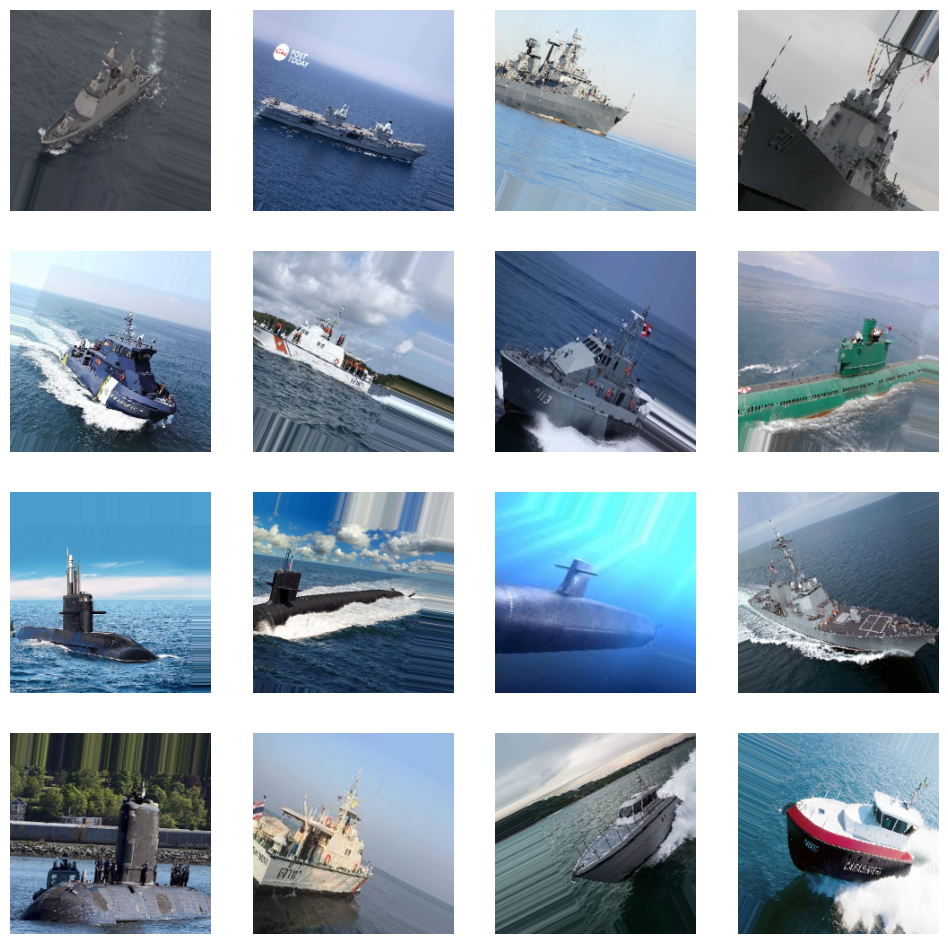

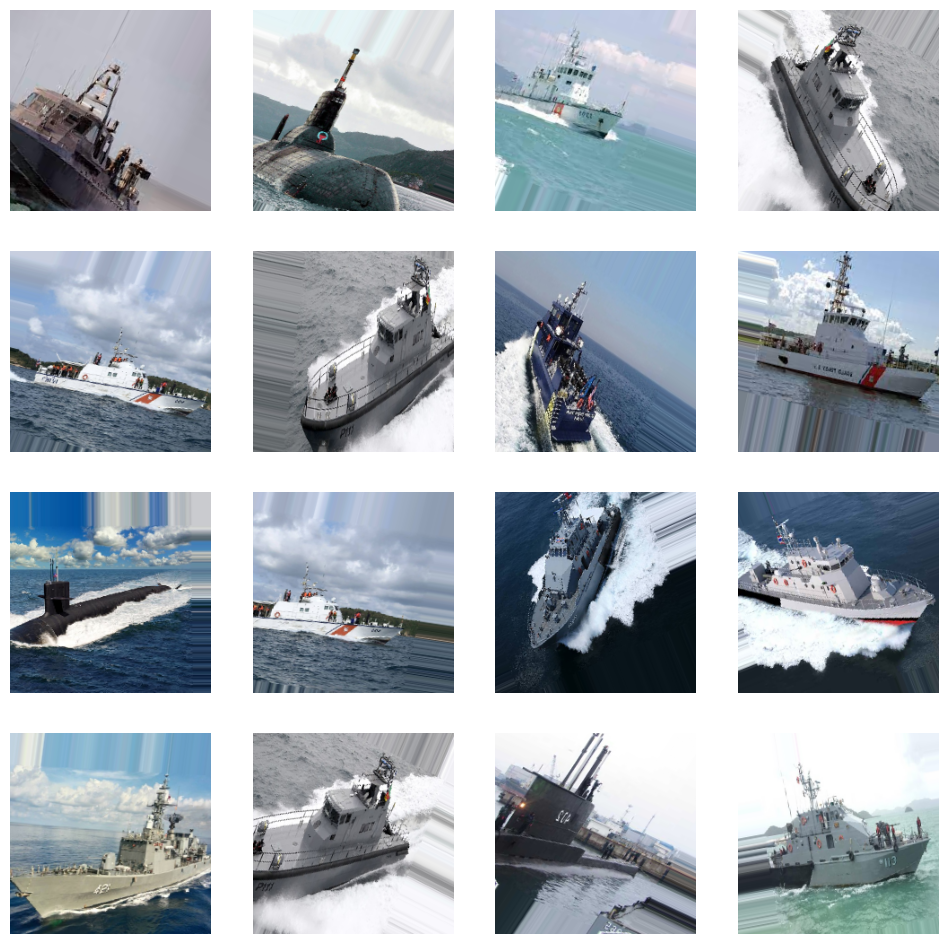

In [17]:
# Create a subplot with a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Display 4x4 training images
for i in range(4):
    for j in range(4):
        # Get a batch of images from the training generator
        batch = train_generator.next()
        
        # Extract the first image from the batch and rescale it
        Img_train = (batch[0][0] + 1) / 2.0
        
        # Display the image in the current subplot
        axes[i, j].imshow(Img_train)
        axes[i, j].axis('off')  # Turn off axis labels
        
# Display the entire plot
plt.show()

# Create another subplot for 4x4 validation images
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Display 4x4 validation images
for i in range(4):
    for j in range(4):
        # Get a batch of images from the validation generator
        batch = val_generator.next()
        
        # Extract the first image from the batch and rescale it
        Img_val = (batch[0][0] + 1) / 2.0
        
        # Display the image in the current subplot
        axes[i, j].imshow(Img_val)
        axes[i, j].axis('off')  # Turn off axis labels
        
# Display the entire plot
plt.show()

In [18]:
# Create Optimizer
opts = Adam(learning_rate=0.0001, use_ema=True)

# Compile the model with the optimizer
model.compile(loss='categorical_crossentropy', optimizer=opts, metrics=['accuracy'])

# Define training Generator Parameters
EP = 100  # Number of iterations (epochs) you want to train for

# Calculate step sizes for training and validation generators
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size

# Check if step sizes are equal and adjust batch size if needed
if step_size_train != step_size_val:
    print("Warning: step_size_train is not equal to step_size_val.")
    print(f"Adjusting batch size for training generator from {train_generator.batch_size} to {val_generator.batch_size}")
    
    # Update the batch size for the training generator to match the validation generator
    train_generator.batch_size = val_generator.batch_size
    
    # Recalculate the step size for the training generator
    step_size_train = train_generator.n // train_generator.batch_size

# Now, you can use EP, step_size_train, and step_size_val in your training loop
for epoch in range(EP):
    # Train the model for one epoch using model.fit_generator()
    model.fit_generator(
        train_generator,
        steps_per_epoch=step_size_train,
        validation_data=val_generator,
        validation_steps=step_size_val
    )

# Your model is trained for EP epochs with adjusted batch size if necessary

Adjusting batch size for training generator from 16 to 16


C:\Users\Wiiil\AppData\Local\Temp\ipykernel_10588\3021058621.py:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


6/6 [==============================] - 5s 936ms/step - loss: 0.4864 - accuracy: 0.8519 - val_loss: 0.4415 - val_accuracy: 0.8438


C:\Users\Wiiil\AppData\Local\Temp\ipykernel_10588\1398425956.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
6/6 [==============================] - 5s 837ms/step - loss: 0.4387 - accuracy: 0.9062 - val_loss: 0.3262 - val_accuracy: 0.9844
Epoch 2/100
6/6 [==============================] - 5s 876ms/step - loss: 0.3284 - accuracy: 0.9136 - val_loss: 0.3715 - val_accuracy: 0.8594
Epoch 3/100
6/6 [==============================] - 5s 824ms/step - loss: 0.2913 - accuracy: 0.9012 - val_loss: 0.2087 - val_accuracy: 0.9844
Epoch 4/100
6/6 [==============================] - 5s 876ms/step - loss: 0.1711 - accuracy: 1.0000 - val_loss: 0.1696 - val_accuracy: 0.9688
Epoch 5/100
6/6 [==============================] - 4s 781ms/step - loss: 0.1426 - accuracy: 0.9753 - val_loss: 0.1657 - val_accuracy: 0.9531
Epoch 6/100
6/6 [==============================] - 4s 727ms/step - loss: 0.1264 - accuracy: 0.9753 - val_loss: 0.2494 - val_accuracy: 0.9375
Epoch 7/100
6/6 [==============================] - 4s 746ms/step - loss: 0.1639 - accuracy: 0.9375 - val_loss: 0.0955 - val_accuracy: 0.9844
Epoch 8/100
6

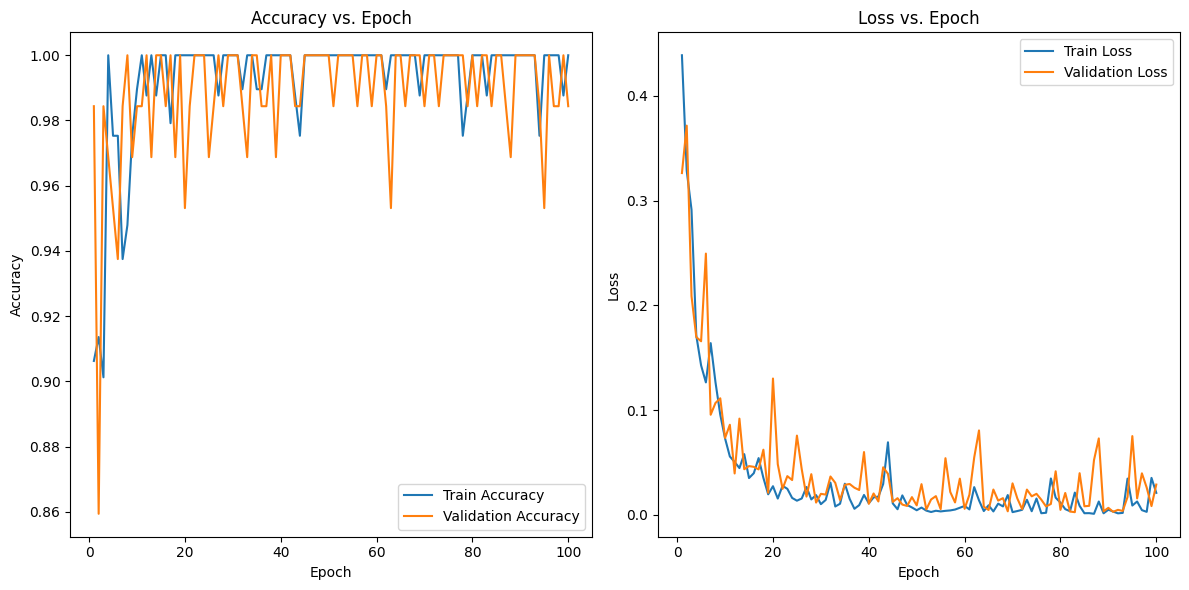

In [19]:
# Train the model and store the training history
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=step_size_train,
    validation_data=val_generator,
    validation_steps=step_size_val,
    epochs=EP,
    verbose=1
)

# Extract the training history
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Create a list of epochs for plotting
N = range(1, EP + 1)

# Performance Visualization
import matplotlib.pyplot as plt

# View Accuracy (Training, Validation)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(N, train_accuracy, label="Train Accuracy")
plt.plot(N, val_accuracy, label="Validation Accuracy")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# View Loss (Training, Validation)
plt.subplot(1, 2, 2)
plt.plot(N, train_loss, label="Train Loss")
plt.plot(N, val_loss, label="Validation Loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [20]:
test_generator = datagen.flow_from_directory(
    './Ship/Test/',
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=1
)

y_true = test_generator.classes

preds = model.predict_generator(test_generator)

print(preds.shape)
print(preds)


Found 15 images belonging to 3 classes.


C:\Users\Wiiil\AppData\Local\Temp\ipykernel_10588\1763660741.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


(15, 3)
[[9.93129671e-01 6.80489792e-03 6.53985408e-05]
 [8.30320597e-01 1.60397038e-01 9.28235892e-03]
 [9.75846410e-01 1.01252971e-02 1.40283806e-02]
 [8.81606102e-01 1.13905124e-01 4.48877225e-03]
 [7.04318583e-01 2.94871300e-01 8.10183352e-04]
 [7.19096046e-04 9.98509824e-01 7.71111459e-04]
 [1.21460907e-04 9.99449551e-01 4.29022999e-04]
 [6.24764757e-03 9.93513584e-01 2.38725945e-04]
 [4.45502155e-06 9.99951482e-01 4.41421216e-05]
 [1.62827928e-04 9.99106705e-01 7.30502768e-04]
 [3.95102287e-03 9.62764830e-07 9.96048033e-01]
 [3.43922788e-04 5.60773915e-05 9.99599993e-01]
 [3.40721407e-03 6.94940379e-03 9.89643335e-01]
 [4.41471639e-04 1.42090674e-03 9.98137593e-01]
 [1.59464173e-06 1.59907190e-03 9.98399317e-01]]


In [22]:
y_pred = np.argmax(preds,axis=1)
print(test_generator.classes)
print(y_pred)

#Calculate confusion matrix, classification report between y_true and df_class
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[[4 0 0]
 [1 5 0]
 [0 0 5]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6
           2       1.00      1.00      1.00         5

    accuracy                           0.93        15
   macro avg       0.93      0.94      0.93        15
weighted avg       0.95      0.93      0.93        15

